<a href="https://colab.research.google.com/github/Minu-kr/2021_Dacon_exercise/blob/main/%ED%95%B4%EC%99%B8%EC%B6%95%EA%B5%AC%EC%84%A0%EC%88%98_%EC%9D%B4%EC%A0%81%EB%A3%8C_%EC%98%88%EC%B8%A1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

목표
선수들의 정보를 바탕으로 이적료 예측 / 시장가격과 능력치간의 관계

 평가 지표 : RMSE

 [파일]
1. FIFA_train.csv : 축구선수의 정보와 능력치 그리고 이적시장 가격이 포함된 데이터
2. FIFA_test.csv : 축구선수의 정보와 능력치가 포함된 데이터 해당 데이터의 선수들의 이적료를 예측해 주시면 됩니다.
3. submission.csv : 답안지의 형식

[상세 설명]
FIFA_train.csv
1. id : 선수 고유의 아이디
2. name : 이름
3. age : 나이
4. continent : 선수들의 국적이 포함되어 있는 대륙입니다
5. contract_until : 선수의 계약기간이 언제까지인지 나타내어 줍니다
6. position : 선수가 선호하는 포지션입니다. ex) 공격수, 수비수 등
7. prefer_foot : 선수가 선호하는 발입니다. ex) 오른발
8. reputation : 선수가 유명한 정도입니다. ex) 높은 수치일 수록 유명한 선수
9. stat_overall : 선수의 현재 능력치 입니다.
10. stat_potential : 선수가 경험 및 노력을 통해 발전할 수 있는 정도입니다.
11. stat_skill_moves : 선수의 개인기 능력치 입니다.
12. value : FIFA가 선정한 선수의 이적 시장 가격 (단위 : 유로) 입니다.

[제출 파일의 형식]
submission.csv : 선수들의 아이디와 그에맞는 이적료가격을 기입하여 제출하여 주시기 바랍니다.

1. id : 선수 고유의 아이디
2. value : 예측된 선수 이적 시장 가격을 기입

In [1]:
# wrangling package
import pandas as pd
import numpy as np
from scipy.stats import norm, skew

import seaborn as sns
import matplotlib.pyplot as plt

# setting package
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

!pip install bayesian-optimization
!pip install ngboost
!pip install catboost
# modeling package
from bayes_opt import BayesianOptimization
from sklearn.model_selection import *
from sklearn.metrics import *
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, VotingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from mlxtend.regressor import StackingCVRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from ngboost import NGBRegressor
from catboost import CatBoostRegressor


  Created wheel for bayesian-optimization: filename=bayesian_optimization-1.2.0-cp36-none-any.whl size=11685 sha256=7d5caa9b71f72b698b11feab327afb7d27e4cb73eb4030cb2762cabd8e42ef0a
  Stored in directory: /root/.cache/pip/wheels/5a/56/ae/e0e3c1fc1954dc3ec712e2df547235ed072b448094d8f94aec
Successfully built bayesian-optimization
     |████████████████████████████████| 348kB 6.7MB/s 
     |████████████████████████████████| 61kB 6.1MB/s 
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-cp36-none-any.whl size=4035 sha256=a08808869a22145e3f05c8af7c46319edb33983843222c936f099ee9bb46d125
  Stored in directory: /root/.cache/pip/wheels/dc/68/dc/91321c55fba449755524481854f5be70d41912b8f886f908bb
Successfully built autograd-gamma
     |████████████████████████████████| 65.8MB 58kB/s 


In [2]:
train = pd.read_csv('FIFA_train.csv',encoding = 'utf-8') # train data
test = pd.read_csv("FIFA_test.csv",encoding = 'utf-8') # test data
submission = pd.read_csv('submission.csv', encoding = 'utf-8') # submission data

In [3]:
train.head()

,id,name,age,continent,contract_until,position,prefer_foot,reputation,stat_overall,stat_potential,stat_skill_moves,value
0,0,L. Messi,31,south america,2021,ST,left,5.0,94,94,4.0,110500000.0
1,3,De Gea,27,europe,2020,GK,right,4.0,91,93,1.0,72000000.0
2,7,L. Suárez,31,south america,2021,ST,right,5.0,91,91,3.0,80000000.0
3,8,Sergio Ramos,32,europe,2020,DF,right,4.0,91,91,3.0,51000000.0
4,9,J. Oblak,25,europe,2021,GK,right,3.0,90,93,1.0,68000000.0


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8932 entries, 0 to 8931
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                8932 non-null   int64  
 1   name              8932 non-null   object 
 2   age               8932 non-null   int64  
 3   continent         8932 non-null   object 
 4   contract_until    8932 non-null   object 
 5   position          8932 non-null   object 
 6   prefer_foot       8932 non-null   object 
 7   reputation        8932 non-null   float64
 8   stat_overall      8932 non-null   int64  
 9   stat_potential    8932 non-null   int64  
 10  stat_skill_moves  8932 non-null   float64
 11  value             8932 non-null   float64
dtypes: float64(3), int64(4), object(5)
memory usage: 837.5+ KB


In [5]:
train.describe(include = 'all')

,id,name,age,continent,contract_until,position,prefer_foot,reputation,stat_overall,stat_potential,stat_skill_moves,value
count,8932.000000,8932,8932.000000,8932,8932,8932,8932,8932.000000,8932.000000,8932.000000,8932.000000,8.932000e+03
unique,NaN,8932,NaN,5,17,4,2,NaN,NaN,NaN,NaN,NaN
top,NaN,F. Bastians,NaN,europe,2019,MF,right,NaN,NaN,NaN,NaN,NaN
freq,NaN,1,NaN,5322,2366,3428,6837,NaN,NaN,NaN,NaN,NaN
mean,7966.775750,NaN,25.209136,NaN,NaN,NaN,NaN,1.130878,67.091133,71.997201,2.401702,2.778673e+06
std,4844.428521,NaN,4.635515,NaN,NaN,NaN,NaN,0.423792,6.854910,5.988147,0.776048,5.840982e+06
min,0.000000,NaN,16.000000,NaN,NaN,NaN,NaN,1.000000,47.000000,48.000000,1.000000,1.000000e+04
25%,3751.750000,NaN,21.000000,NaN,NaN,NaN,NaN,1.000000,63.000000,68.000000,2.000000,3.750000e+05
50%,7696.500000,NaN,25.000000,NaN,NaN,NaN,NaN,1.000000,67.000000,72.000000,2.000000,8.250000e+05
75%,12082.250000,NaN,28.000000,NaN,NaN,NaN,NaN,1.000000,72.000000,76.000000,3.000000,2.600000e+06


In [6]:
test.describe(include = 'all')

,id,name,age,continent,contract_until,position,prefer_foot,reputation,stat_overall,stat_potential,stat_skill_moves
count,3828.000000,3828,3828.000000,3828,3828,3828,3828,3828.000000,3828.000000,3828.000000,3828.000000
unique,NaN,3828,NaN,5,18,4,2,NaN,NaN,NaN,NaN
top,NaN,D. Rosero Valencia,NaN,europe,2021,MF,right,NaN,NaN,NaN,NaN
freq,NaN,1,NaN,2269,985,1431,2915,NaN,NaN,NaN,NaN
mean,7846.258098,NaN,25.297806,NaN,NaN,NaN,NaN,1.143939,67.336991,72.107628,2.414838
std,4870.339361,NaN,4.628236,NaN,NaN,NaN,NaN,0.448465,6.908814,6.133428,0.781153
min,1.000000,NaN,16.000000,NaN,NaN,NaN,NaN,1.000000,47.000000,52.000000,1.000000
25%,3466.250000,NaN,22.000000,NaN,NaN,NaN,NaN,1.000000,63.000000,68.000000,2.000000
50%,7643.500000,NaN,25.000000,NaN,NaN,NaN,NaN,1.000000,67.000000,72.000000,2.000000
75%,11967.000000,NaN,29.000000,NaN,NaN,NaN,NaN,1.000000,72.000000,76.000000,3.000000


In [7]:
#선수 고유 id, name 은 이적료와 관련이 없으므로 삭제
train.drop(['id', 'name'], axis = 1, inplace = True)
test.drop(['id', 'name'], axis = 1, inplace = True)

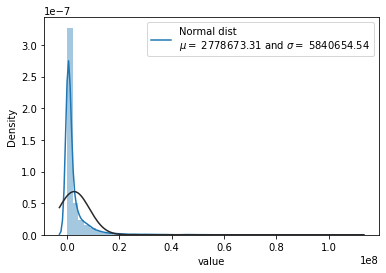

In [8]:
#예측 대상인 value 컬럼의 왜도 확인
sns.distplot(train.value, fit = norm)
(mu, sigma) = norm.fit(train['value'])
plt.legend(['Normal dist\n$\mu=$ {:.2f} and $\sigma=$ {:.2f}'.format(mu, sigma)], loc = 'best')
plt.show()

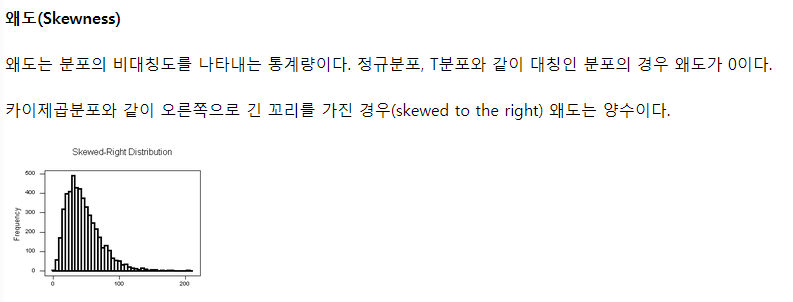

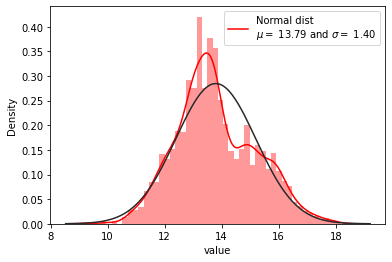

In [9]:
#
sns.distplot(np.log1p(train.value), fit = norm, color = 'r')
(mu, sigma) = norm.fit(np.log1p(train['value']))
plt.legend(['Normal dist\n$\mu=$ {:.2f} and $\sigma=$ {:.2f}'.format(mu, sigma)],loc = 'best')
plt.show()

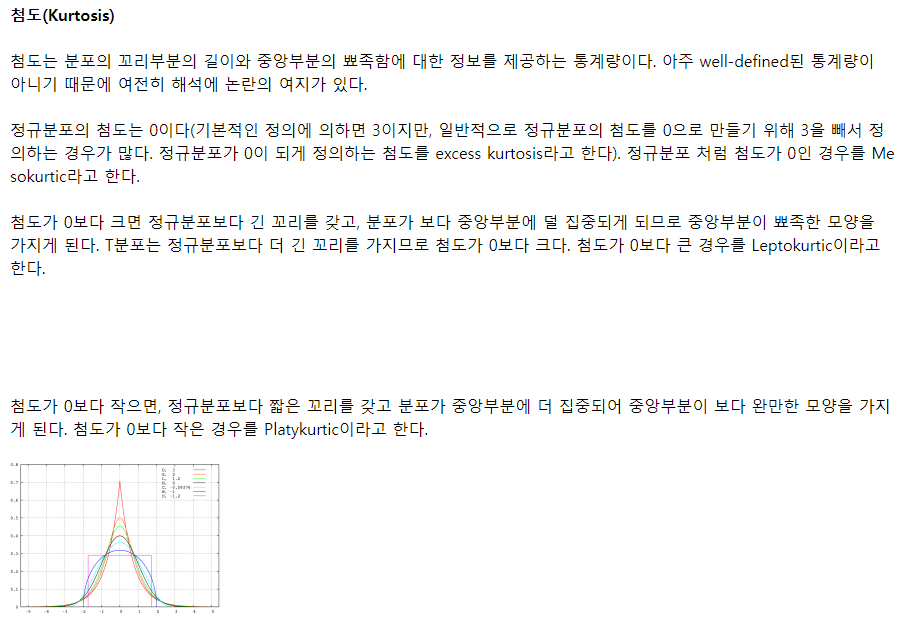

In [10]:
train['value']

0       110500000.0
1        72000000.0
2        80000000.0
3        51000000.0
4        68000000.0
           ...     
8927        60000.0
8928        40000.0
8929        50000.0
8930        50000.0
8931        60000.0
Name: value, Length: 8932, dtype: float64

In [11]:
#train의 value 값이 너무 큰 격차를 보이므로 log를 통해 완만화 한다.
train.value = np.log1p(train.value)

In [12]:
#남은 계약 기간을 얻기 위해서 계약종료시점-자료제공시점 실시
train['contract'] = 2018
test['contract'] = 2018

In [13]:
#특이값들 날짜들 숫자로 변환
def con_period(x):
    if x == 'Dec 31, 2018' :
        return '2019'
    elif x == 'Jun 30, 2020' :
        return '2020.5'
    elif x == 'Jun 30, 2019' :
        return '2019.5'
    elif x == 'May 31, 2020' :
        return '2020.3333'
    elif x == 'May 31, 2019' :
        return '2019.3333'
    elif x == 'Jan 31, 2019' :
        return '2019.0833'
    elif x == 'Jan 1, 2019' :
        return '2019'
    elif x == 'Jan 12, 2019' :
        return '2019.034'
    elif x == 'Dec 31, 2019' :
        return '2020'
    elif x == 'Jun 1, 2019' :
        return '2019.416'
    else :
        return x

In [14]:
#남은 계약기간 = 남은계약기간을 기준선 정립해서 나누고 실수로 타입변환(계산하기위해서)
train.contract_until = train.contract_until.apply(con_period).astype('float64')
test.contract_until = test.contract_until.apply(con_period).astype('float64')

In [15]:
#남은 계약기간 구하기
#train.contract_until = train.contract_until - train.contract
train.contract_until -= train.contract
test.contract_until -= test.contract 

In [16]:
#contract는 이제 필요없으므로 드랍
train.drop('contract', axis = 1, inplace = True)
test.drop('contract', axis = 1, inplace = True)

In [17]:
#포지션, 주발, 대륙등 문자 데이터는 계산할 수 없으므로 더미화 실시
train = pd.get_dummies(columns = ['continent', 'position', 'prefer_foot'], data = train)
test = pd.get_dummies(columns = ['continent', 'position', 'prefer_foot'], data = test)

In [18]:
#X_train에는 독립변수 만 있어야하므로 value 드랍
X = train.drop('value', axis = 1)
y = train.value

In [19]:
#왜도가 높은 컬럼 로그 변환 => 편차가 큰 속성들
X[['age','reputation', 'stat_potential']] = np.log1p(X[['age','reputation', 'stat_potential']])

In [20]:
#테스트 값도 마찬가지로 로그 변환
test[['age','reputation', 'stat_potential']] = np.log1p(test[['age','reputation', 'stat_potential']])

In [21]:
scaler = StandardScaler()

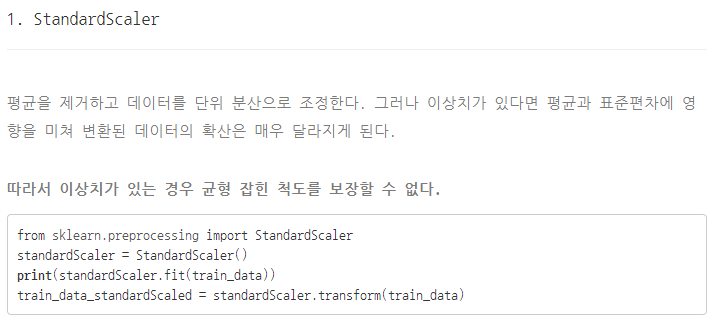

In [22]:
#스케일러를 X_train에 적용
X = pd.DataFrame(scaler.fit_transform(X), columns = X.columns)

In [23]:
#test에도 마찬가지 적용
test = pd.DataFrame(scaler.fit_transform(test), columns = test.columns)

4. 모델링

4-1) NGBRegressor

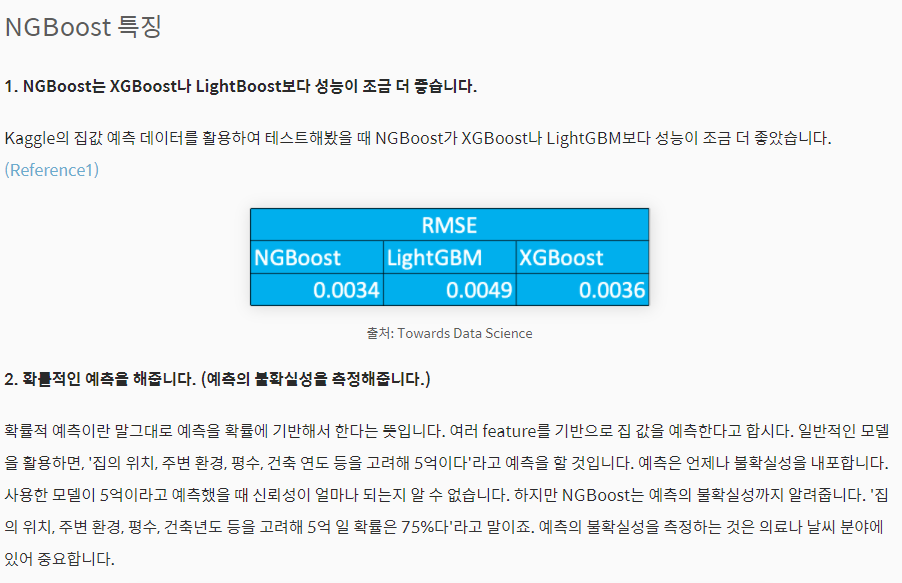

In [24]:
#2020이라는 지점으로 ngb객체 생성
ngb = NGBRegressor(random_state = 2020)

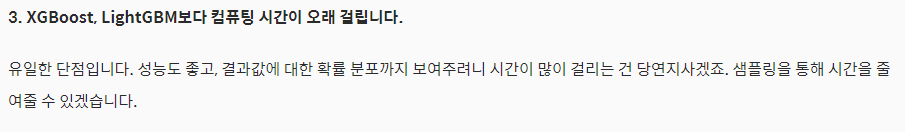

In [25]:
#ngb모델의 성적을 측정하기 위해 X, y를 넣고 교차검증 실시(점수산정방식 : neg_mean_squard_error)
#cross_val_score에 들어가는 매개변수는 (모델 명, 훈련데이터, 타깃, cv)인데, 여기에서 cv는 폴드(fold)수
cv_ngb = cross_val_score(ngb, X, y, cv = KFold(n_splits = 4, random_state = 1011, shuffle = True), scoring = 'neg_mean_squared_error')
cv_ngb.mean()
#-0.008정도 : 0에 가까울수록 정확하다

[iter 0] loss=1.7590 val_loss=0.0000 scale=1.0000 norm=1.2891
[iter 100] loss=0.7767 val_loss=0.0000 scale=2.0000 norm=1.1218
[iter 200] loss=-0.0925 val_loss=0.0000 scale=2.0000 norm=0.9237
[iter 300] loss=-0.7624 val_loss=0.0000 scale=2.0000 norm=0.8157
[iter 400] loss=-1.0853 val_loss=0.0000 scale=2.0000 norm=0.8450
[iter 0] loss=1.7475 val_loss=0.0000 scale=1.0000 norm=1.2784
[iter 100] loss=0.7661 val_loss=0.0000 scale=2.0000 norm=1.1156
[iter 200] loss=-0.1014 val_loss=0.0000 scale=2.0000 norm=0.9212
[iter 300] loss=-0.7714 val_loss=0.0000 scale=2.0000 norm=0.8175
[iter 400] loss=-1.0888 val_loss=0.0000 scale=2.0000 norm=0.8573
[iter 0] loss=1.7558 val_loss=0.0000 scale=1.0000 norm=1.2850
[iter 100] loss=0.8024 val_loss=0.0000 scale=2.0000 norm=1.1342
[iter 200] loss=-0.0653 val_loss=0.0000 scale=2.0000 norm=0.9245
[iter 300] loss=-0.7359 val_loss=0.0000 scale=2.0000 norm=0.8125
[iter 400] loss=-1.0571 val_loss=0.0000 scale=1.0000 norm=0.4184
[iter 0] loss=1.7639 val_loss=0.0000 

-0.008559248129320574

In [26]:
#샘플링 된 ngb모델에 X, y 학습
ngb.fit(X, y)

[iter 0] loss=1.7566 val_loss=0.0000 scale=1.0000 norm=1.2863
[iter 100] loss=0.7615 val_loss=0.0000 scale=2.0000 norm=1.1144
[iter 200] loss=-0.1036 val_loss=0.0000 scale=2.0000 norm=0.9212
[iter 300] loss=-0.7664 val_loss=0.0000 scale=2.0000 norm=0.8156
[iter 400] loss=-1.0822 val_loss=0.0000 scale=2.0000 norm=0.8468


NGBRegressor(Base=DecisionTreeRegressor(ccp_alpha=0.0, criterion='friedman_mse',
                                        max_depth=3, max_features=None,
                                        max_leaf_nodes=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=1, min_samples_split=2,
                                        min_weight_fraction_leaf=0.0,
                                        presort='deprecated', random_state=None,
                                        splitter='best'),
             Dist=<class 'ngboost.distns.normal.Normal'>,
             Score=<class 'ngboost.scores.LogScore'>, col_sample=1.0,
             learning_rate=0.01, minibatch_frac=1.0, n_estimators=500,
             natural_gradient=True,
             random_state=RandomState(MT19937) at 0x7FB3BE212780, tol=0.0001,
             verbose=True, verbose_eval=100)

In [27]:
#예측치에 저장
pred_ngb = np.expm1(ngb.predict(test))

4-2) CatBoostRegressor

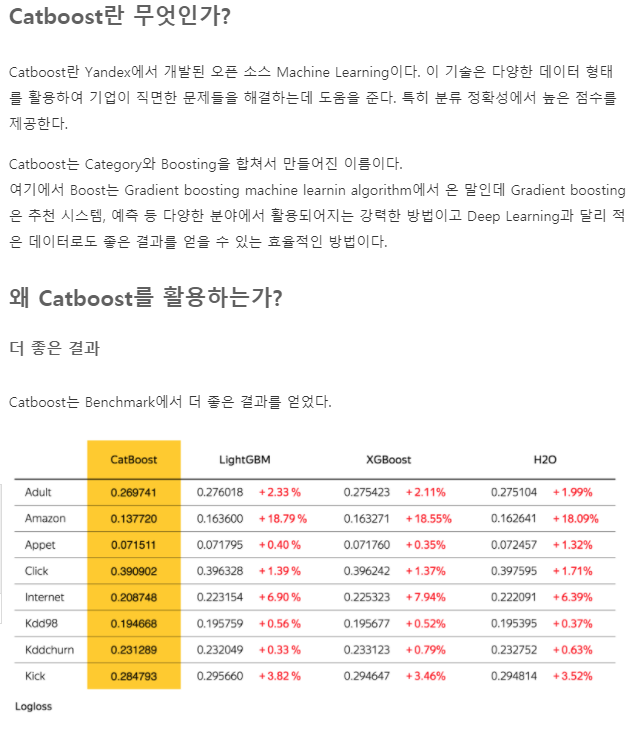

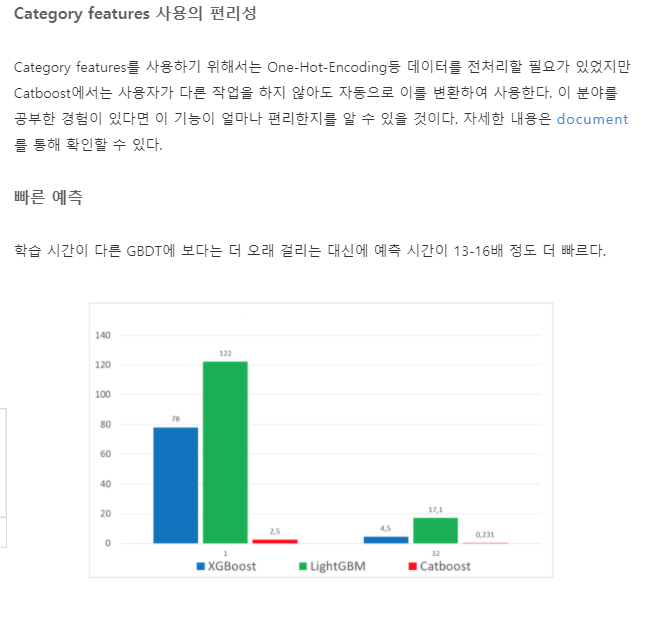

In [28]:
#여러 깊이와 러닝 비율을 줘서 실험을 실시
param = {
        'depth' : [2,3,4,5,6,7,8,9,10],
        'learning_rate' : [0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.2, 0.25]
         }

In [29]:
#그리디 서치 방식으로 최고의 조합을 알아냄
grid_cat = GridSearchCV(CatBoostRegressor(random_state = 1011), param, cv = KFold(n_splits = 4, shuffle = True, random_state = 1011), scoring = 'neg_mean_squared_error', n_jobs = -1)

In [30]:
#학습 시작
grid_cat.fit(X, y)

0:	learn: 1.1766980	total: 48.6ms	remaining: 48.6s
1:	learn: 0.9929251	total: 50.5ms	remaining: 25.2s
2:	learn: 0.8373167	total: 52.3ms	remaining: 17.4s
3:	learn: 0.7170664	total: 54ms	remaining: 13.5s
4:	learn: 0.6178283	total: 55.5ms	remaining: 11s
5:	learn: 0.5339420	total: 57.1ms	remaining: 9.46s
6:	learn: 0.4635013	total: 58.7ms	remaining: 8.32s
7:	learn: 0.4088383	total: 60.3ms	remaining: 7.47s
8:	learn: 0.3659289	total: 61.9ms	remaining: 6.81s
9:	learn: 0.3239334	total: 63.6ms	remaining: 6.29s
10:	learn: 0.2928689	total: 65.2ms	remaining: 5.86s
11:	learn: 0.2642994	total: 66.9ms	remaining: 5.5s
12:	learn: 0.2413847	total: 68.3ms	remaining: 5.18s
13:	learn: 0.2215522	total: 69.8ms	remaining: 4.91s
14:	learn: 0.2035851	total: 71.4ms	remaining: 4.69s
15:	learn: 0.1892678	total: 72.9ms	remaining: 4.48s
16:	learn: 0.1781422	total: 74.4ms	remaining: 4.3s
17:	learn: 0.1690731	total: 76ms	remaining: 4.14s
18:	learn: 0.1606283	total: 77.5ms	remaining: 4s
19:	learn: 0.1531369	total: 78.9m

GridSearchCV(cv=KFold(n_splits=4, random_state=1011, shuffle=True),
             error_score=nan,
             estimator=<catboost.core.CatBoostRegressor object at 0x7fb3b384aa58>,
             iid='deprecated', n_jobs=-1,
             param_grid={'depth': [2, 3, 4, 5, 6, 7, 8, 9, 10],
                         'learning_rate': [0.0005, 0.001, 0.005, 0.01, 0.05,
                                           0.1, 0.2, 0.25]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_mean_squared_error', verbose=0)

In [31]:
#최고의 조합을 cat에 저장
cat = CatBoostRegressor(random_state = 2020, **grid_cat.best_params_)


In [32]:
#학습
cat.fit(X, y)

0:	learn: 1.1694025	total: 1.89ms	remaining: 1.88s
1:	learn: 0.9841204	total: 3.4ms	remaining: 1.7s
2:	learn: 0.8340927	total: 5.39ms	remaining: 1.79s
3:	learn: 0.7056034	total: 8.12ms	remaining: 2.02s
4:	learn: 0.6079531	total: 9.92ms	remaining: 1.97s
5:	learn: 0.5308715	total: 11.6ms	remaining: 1.93s
6:	learn: 0.4633655	total: 13.3ms	remaining: 1.88s
7:	learn: 0.4025279	total: 14.8ms	remaining: 1.83s
8:	learn: 0.3536280	total: 16.3ms	remaining: 1.79s
9:	learn: 0.3193523	total: 17.8ms	remaining: 1.77s
10:	learn: 0.2835587	total: 19.4ms	remaining: 1.75s
11:	learn: 0.2570999	total: 20.9ms	remaining: 1.72s
12:	learn: 0.2347348	total: 22.4ms	remaining: 1.7s
13:	learn: 0.2180353	total: 24.1ms	remaining: 1.69s
14:	learn: 0.2026086	total: 25.5ms	remaining: 1.68s
15:	learn: 0.1891756	total: 27.1ms	remaining: 1.66s
16:	learn: 0.1776611	total: 28.8ms	remaining: 1.66s
17:	learn: 0.1682251	total: 30.3ms	remaining: 1.65s
18:	learn: 0.1604591	total: 31.7ms	remaining: 1.64s
19:	learn: 0.1538147	tota

In [33]:
#예측결과 저장
pred_cat = np.expm1(cat.predict(test))

4-3) XGBoostRegressor + BayesianOptimization

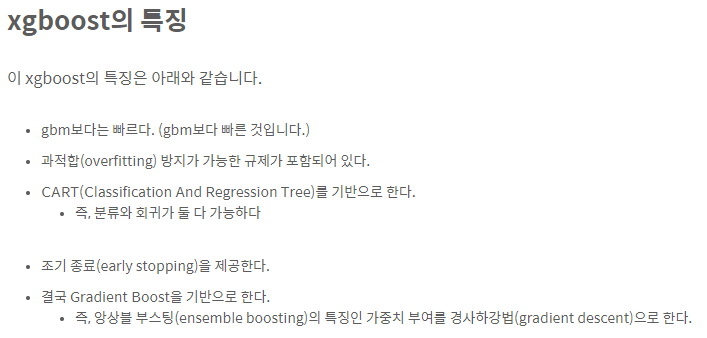

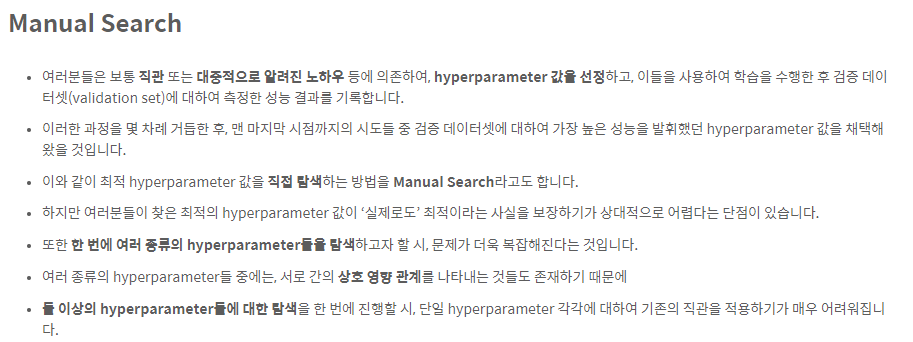

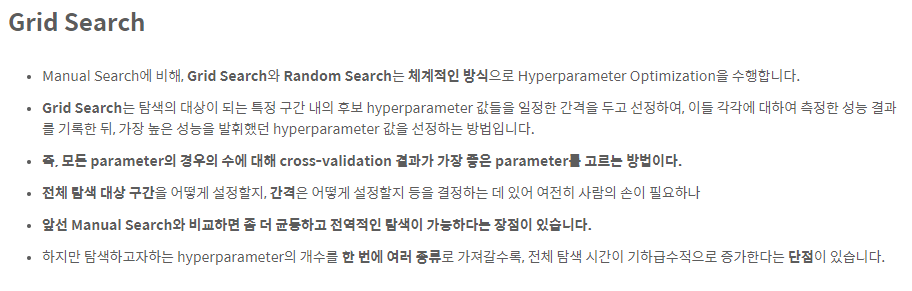

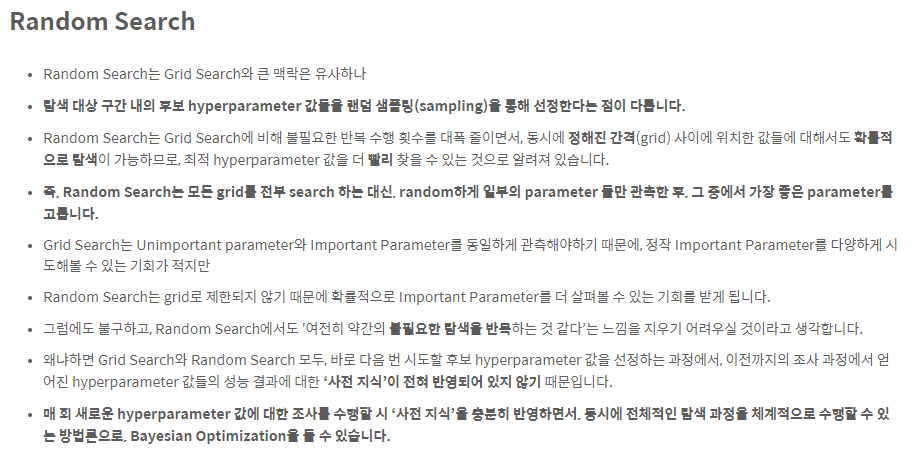

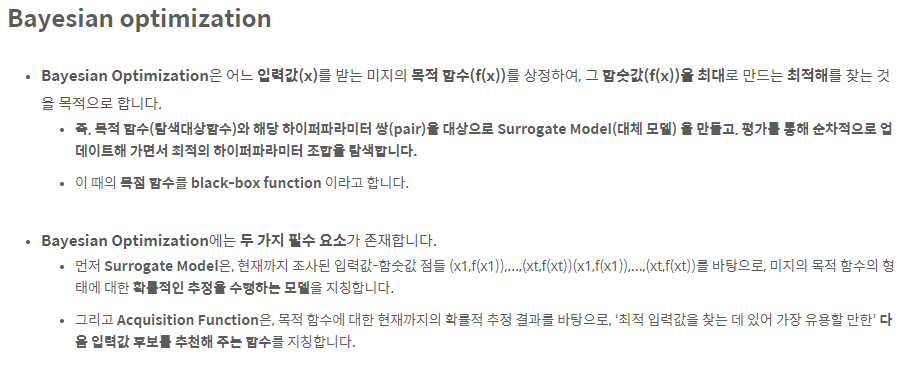

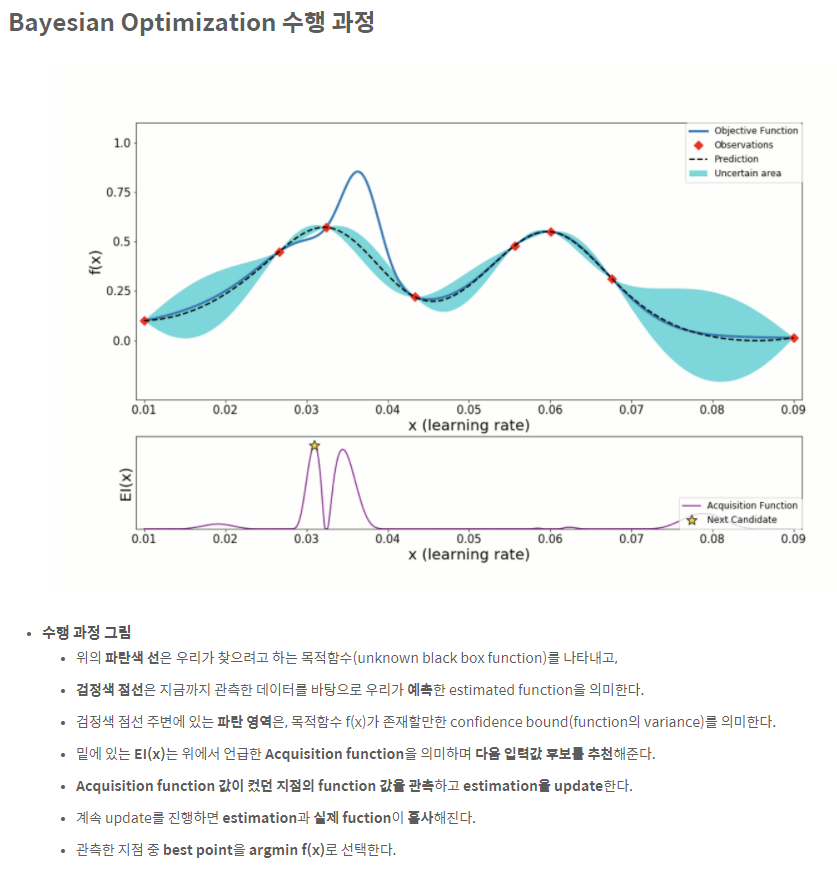

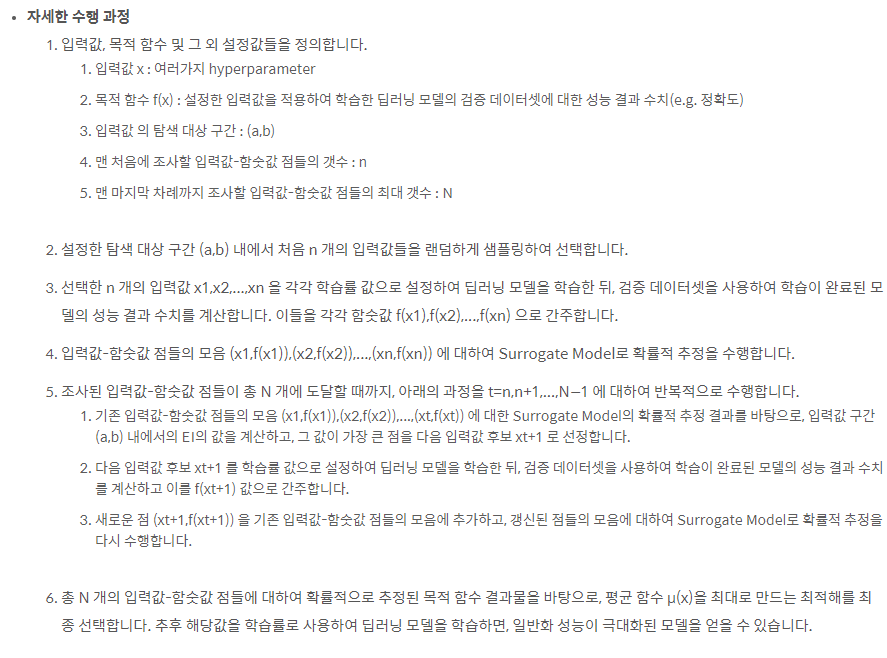

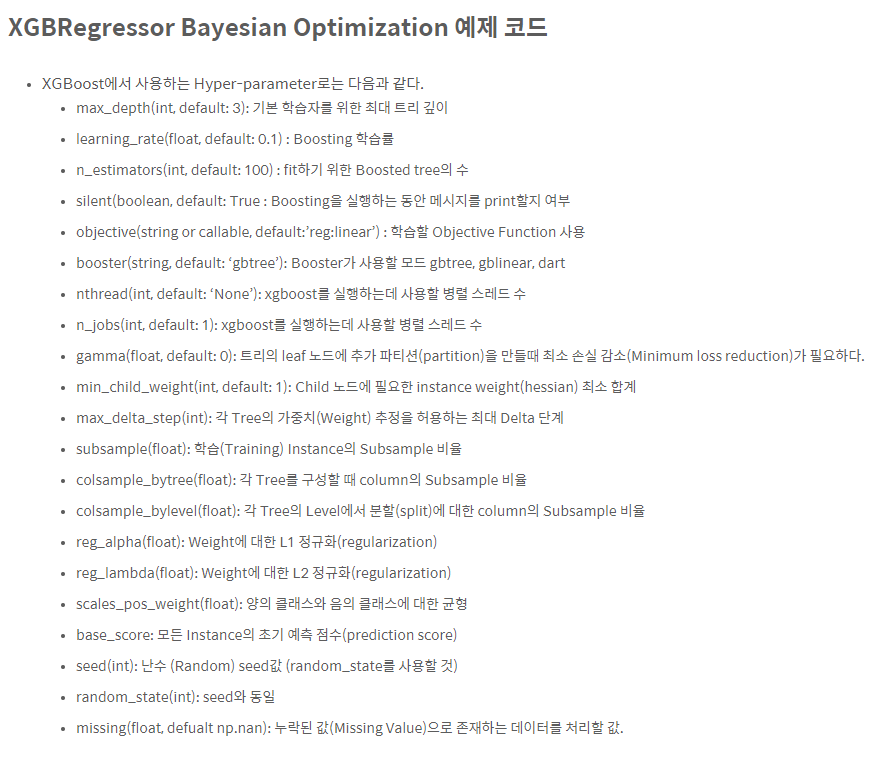

In [34]:
# 하이퍼 파라미터 범위

pbounds = { 'learning_rate': (0.0001, 0.4),
            'n_estimators': (16, 1024),
            'max_depth': (3,10),   
            'subsample': (0.5, 1),  
            'colsample_bytree': (0.5, 1),   
            'gamma': (0, 5)}

def xgb_opt(learning_rate, n_estimators, max_depth, subsample, colsample_bytree, gamma):
    
    params = {
        'learning_rate': learning_rate,
        'n_estimators' : int(round(n_estimators)),
        'max_depth' : int(round(max_depth)),
        'subsample': subsample,
        'colsample': colsample_bytree,   
        'gamma': gamma,
        'n_jobs' : -1,
        'random_state' : 777
    }
    
    xgb = XGBRegressor(**params)
    
    kf = KFold(n_splits = 4 , shuffle=True, random_state=50)

    score = cross_val_score(xgb, X, y, scoring='neg_mean_squared_error', cv=kf, n_jobs=-1)
    
    return np.mean(score)

BO_xgb = BayesianOptimization(f = xgb_opt, pbounds = pbounds, random_state=0)

In [35]:
BO_xgb.maximize(init_points = 10, n_iter = 200)

|   iter    |  target   | colsam... |   gamma   | learni... | max_depth | n_esti... | subsample |
-------------------------------------------------------------------------------------------------
|  1        | -0.01795  |  0.7744   |  3.576    |  0.2411   |  6.814    |  443.0    |  0.8229   |
|  2        | -0.02445  |  0.7188   |  4.459    |  0.3855   |  5.684    |  814.1    |  0.7644   |
|  3        | -22.44    |  0.784    |  4.628    |  0.02851  |  3.61     |  36.38    |  0.9163   |
|  4        | -0.02118  |  0.8891   |  4.35     |  0.3914   |  8.594    |  481.2    |  0.8903   |
|  5        | -0.01511  |  0.5591   |  3.2      |  0.05743  |  9.613    |  542.0    |  0.7073   |
|  6        | -0.01732  |  0.6323   |  3.871    |  0.1825   |  6.979    |  34.94    |  0.8088   |
|  7        | -0.02073  |  0.806    |  3.085    |  0.3775   |  7.773    |  378.4    |  0.7185   |
|  8        | -0.009018 |  0.8488   |  0.3011   |  0.2667   |  7.694    |  228.1    |  0.5645   |
|  9        | -0.015

In [37]:
BO_xgb.max

{'params': {'colsample_bytree': 0.5077862500013182,
  'gamma': 0.04360905322972397,
  'learning_rate': 0.08216538168209876,
  'max_depth': 5.4789444222025185,
  'n_estimators': 570.2837921082393,
  'subsample': 0.8848282063597044},
 'target': -0.00530820637106056}

In [38]:
params = BO_xgb.max['params']
params['max_depth'] = int(round(params['max_depth']))
params['n_estimators'] = int(round(params['n_estimators']))

In [39]:
xgb = XGBRegressor(random_state = 777, **params)

In [40]:
xgb.fit(X, y)

[01:21:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.5077862500013182,
             gamma=0.04360905322972397, importance_type='gain',
             learning_rate=0.08216538168209876, max_delta_step=0, max_depth=5,
             min_child_weight=1, missing=None, n_estimators=570, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=777,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=0.8848282063597044, verbosity=1)

In [41]:
pred_xgb = np.expm1(xgb.predict(test))

4-4) LGBMRegressor + BayesianOptimization

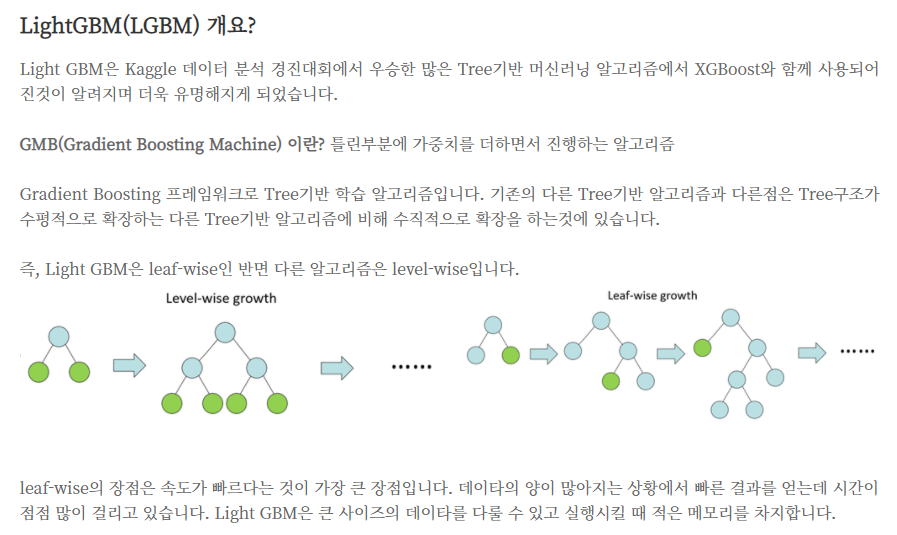

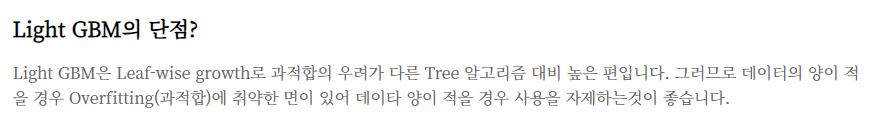

In [42]:
pbounds = { 'learning_rate': (0.0005, 0.2),
            'n_estimators': (16, 1024),
            'max_depth': (3,10),   
            'subsample': (0.5,1), 
            'colsample_bytree': (0.5,1),   
            'num_leaves': (2,16),
            'min_child_weight': (1, 10)}


def lgbm_opt(learning_rate, n_estimators, max_depth, subsample, colsample_bytree, num_leaves, min_child_weight):

    params = {
        'learning_rate': learning_rate,
        'n_estimators' : int(round(n_estimators)),
        'max_depth' : int(round(max_depth)),
        'subsample': subsample,
        'colsample_bytree' : colsample_bytree,
        'num_leaves' : int(round(num_leaves)),
        'min_child_weight' : min_child_weight,
        'n_jobs' : -1
    }
    
    lgbm = LGBMRegressor(**params)
    
    kf = KFold(n_splits=4 , shuffle=True, random_state=50)

    score = cross_val_score(lgbm, X, y, scoring='neg_mean_squared_error', cv=kf, n_jobs=-1)
    
    return np.mean(score)

BO_lgbm = BayesianOptimization(f = lgbm_opt, pbounds = pbounds, random_state=1)    

In [43]:
BO_lgbm.maximize(init_points=10, n_iter = 200)

|   iter    |  target   | colsam... | learni... | max_depth | min_ch... | n_esti... | num_le... | subsample |
-------------------------------------------------------------------------------------------------------------
|  1        | -0.008573 |  0.7085   |  0.1442   |  3.001    |  3.721    |  163.9    |  3.293    |  0.5931   |
|  2        | -0.005609 |  0.6728   |  0.07966  |  6.772    |  4.773    |  706.7    |  4.862    |  0.9391   |
|  3        | -0.009932 |  0.5137   |  0.1343   |  5.921    |  6.028    |  157.5    |  4.773    |  0.9004   |
|  4        | -0.006451 |  0.9841   |  0.06303  |  7.846    |  8.888    |  917.8    |  3.191    |  0.5195   |
|  5        | -0.004511 |  0.5849   |  0.1757   |  3.688    |  4.79     |  981.6    |  9.464    |  0.8459   |
|  6        | -0.004874 |  0.6578   |  0.1375   |  8.842    |  1.165    |  772.1    |  15.84    |  0.8741   |
|  7        | -0.004528 |  0.6402   |  0.158    |  3.723    |  5.031    |  931.9    |  6.111    |  0.6439   |
|  8      

In [44]:
BO_lgbm.max

{'params': {'colsample_bytree': 0.5849152097822845,
  'learning_rate': 0.17568942943416793,
  'max_depth': 3.688427836831351,
  'min_child_weight': 4.78996862504547,
  'n_estimators': 981.5526463917059,
  'num_leaves': 9.464313989622239,
  'subsample': 0.8459385569752367},
 'target': -0.004511167365824896}

In [45]:
params = BO_lgbm.max['params']
params['max_depth'] = int(round(params['max_depth']))
params['n_estimators'] = int(round(params['n_estimators']))
params['num_leaves'] = int(round(params['num_leaves']))

In [46]:
lgbm = LGBMRegressor(seed = 1011, **params)

In [47]:
lgbm.fit(X, y)

LGBMRegressor(boosting_type='gbdt', class_weight=None,
              colsample_bytree=0.5849152097822845, importance_type='split',
              learning_rate=0.17568942943416793, max_depth=4,
              min_child_samples=20, min_child_weight=4.78996862504547,
              min_split_gain=0.0, n_estimators=982, n_jobs=-1, num_leaves=9,
              objective=None, random_state=None, reg_alpha=0.0, reg_lambda=0.0,
              seed=1011, silent=True, subsample=0.8459385569752367,
              subsample_for_bin=200000, subsample_freq=0)

In [48]:
pred_lgbm = np.expm1(lgbm.predict(test))

4-5) GradientBoostingRegressor + BayesianOptimization

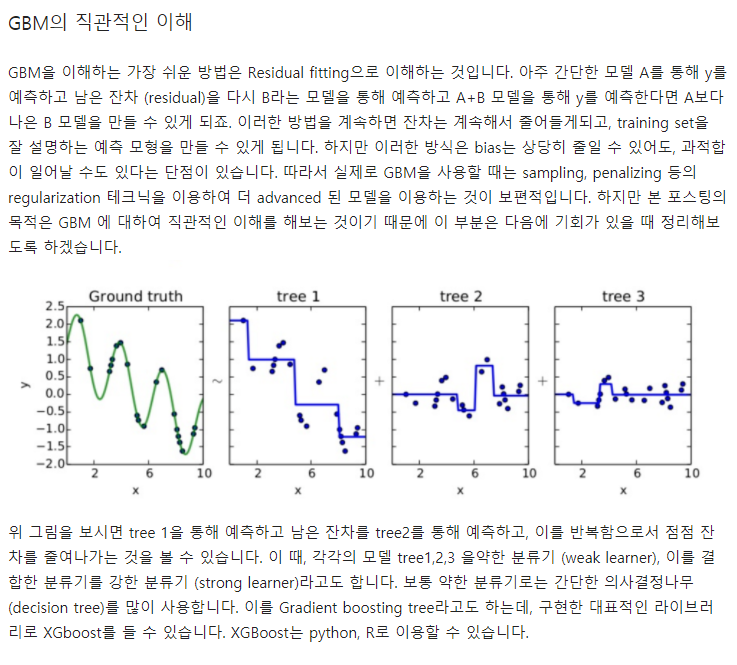

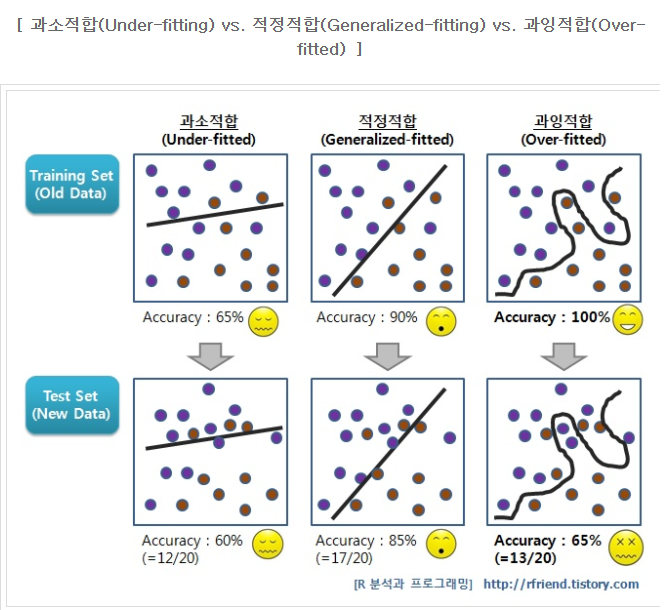

In [49]:
pbounds = { 'learning_rate': (0.0005, 0.2),
            'n_estimators': (16, 512),
            'max_depth': (3,10),   
            'subsample': (0.5,1), 
            'min_samples_split': (2,5),   
            'min_samples_leaf': (1,5)}

def gbm_opt(learning_rate, n_estimators, max_depth, subsample, min_samples_split, min_samples_leaf):

    params = {
        'learning_rate': learning_rate,
        'n_estimators' : int(round(n_estimators)),
        'max_depth' : int(round(max_depth)),
        'subsample': subsample,
        'min_samples_split' : int(round(min_samples_split)),
        'min_samples_leaf' : int(round(min_samples_leaf))
    }
    
    gbm = GradientBoostingRegressor(**params)
    kf = KFold(n_splits = 4 , shuffle = True, random_state=50)
    score = cross_val_score(gbm, X, y, scoring='neg_mean_squared_error', cv = kf, n_jobs=-1)
    return np.mean(score)

BO_gbm = BayesianOptimization(f = gbm_opt, pbounds = pbounds, random_state=0)    

In [50]:
BO_gbm.maximize(init_points = 10, n_iter = 200)

|   iter    |  target   | learni... | max_depth | min_sa... | min_sa... | n_esti... | subsample |
-------------------------------------------------------------------------------------------------
|  1        | -0.006711 |  0.11     |  8.006    |  3.411    |  3.635    |  226.1    |  0.8229   |
|  2        | -0.006539 |  0.0878   |  9.242    |  4.855    |  3.15     |  408.7    |  0.7644   |
|  3        | -0.01188  |  0.1138   |  9.479    |  1.284    |  2.261    |  26.03    |  0.9163   |
|  4        | -0.006856 |  0.1557   |  9.09     |  4.914    |  4.397    |  244.9    |  0.8903   |
|  5        | -0.005856 |  0.0241   |  7.479    |  1.573    |  4.834    |  274.8    |  0.7073   |
|  6        | -0.1413   |  0.05328  |  8.42     |  2.825    |  3.705    |  25.32    |  0.8088   |
|  7        | -0.005711 |  0.1226   |  7.319    |  4.775    |  4.045    |  194.3    |  0.7185   |
|  8        | -0.007231 |  0.1397   |  3.422    |  3.667    |  4.012    |  120.3    |  0.5645   |
|  9        | -0.005

In [51]:
BO_gbm.max

{'params': {'learning_rate': 0.18902555860616094,
  'max_depth': 3.3210115251197436,
  'min_samples_leaf': 4.416711649652251,
  'min_samples_split': 2.1314104881126417,
  'n_estimators': 471.4614053591388,
  'subsample': 0.6844350836295845},
 'target': -0.004719472725561532}

In [52]:
params = BO_gbm.max['params']
params['max_depth'] = int(round(params['max_depth']))
params['n_estimators'] = int(round(params['n_estimators']))
params['min_samples_leaf'] = int(round(params['min_samples_leaf']))
params['min_samples_split'] = int(round(params['min_samples_split']))

In [53]:
gbm = GradientBoostingRegressor(random_state = 123, **params)
gbm.fit(X, y)
pred_gbm = np.expm1(gbm.predict(test))

4-6) VotingRegressor

회귀모형들을 votingRegressor()에 넣어 훈련시키고 성능을 살펴본다.
RMSE 값을 기억했다가 더 성능 좋은 모형과 비교한다.

In [54]:
vot = VotingRegressor(estimators = [('lgbm', lgbm), ('xgb' ,xgb), ('gbm', gbm), ('cat', cat)], weights = [.2, .1, .3, .4])

In [55]:
vot.fit(X, y)

[01:57:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
0:	learn: 1.1694025	total: 2.23ms	remaining: 2.23s
1:	learn: 0.9841204	total: 4.17ms	remaining: 2.08s
2:	learn: 0.8340927	total: 5.85ms	remaining: 1.94s
3:	learn: 0.7056034	total: 7.44ms	remaining: 1.85s
4:	learn: 0.6079531	total: 9.13ms	remaining: 1.82s
5:	learn: 0.5308715	total: 10.9ms	remaining: 1.81s
6:	learn: 0.4633655	total: 12.7ms	remaining: 1.79s
7:	learn: 0.4025279	total: 14.3ms	remaining: 1.77s
8:	learn: 0.3536280	total: 15.9ms	remaining: 1.75s
9:	learn: 0.3193523	total: 17.5ms	remaining: 1.74s
10:	learn: 0.2835587	total: 19.2ms	remaining: 1.72s
11:	learn: 0.2570999	total: 20.8ms	remaining: 1.71s
12:	learn: 0.2347348	total: 22.5ms	remaining: 1.71s
13:	learn: 0.2180353	total: 24.2ms	remaining: 1.71s
14:	learn: 0.2026086	total: 25.9ms	remaining: 1.7s
15:	learn: 0.1891756	total: 27.5ms	remaining: 1.69s
16:	learn: 0.1776611	total: 29.2ms	remaining: 1.69s


VotingRegressor(estimators=[('lgbm',
                             LGBMRegressor(boosting_type='gbdt',
                                           class_weight=None,
                                           colsample_bytree=0.5849152097822845,
                                           importance_type='split',
                                           learning_rate=0.17568942943416793,
                                           max_depth=4, min_child_samples=20,
                                           min_child_weight=4.78996862504547,
                                           min_split_gain=0.0, n_estimators=982,
                                           n_jobs=-1, num_leaves=9,
                                           objective=None, random_state=None,
                                           reg_alph...
                                                       min_impurity_split=None,
                                                       min_samples_leaf=4,
                 

In [56]:
pred_vot = np.expm1(vot.predict(test))

4-7) StackingCVRegressor(다중 알고리즘 구현 방법)

스태킹(stacking)은 앞서 예측모형으로 예측을 한 후에 다시 한번 예측모형을 적용한다는 점에서 앞선 모형과 차이가 난다. 이를 구현한 mlxtend가 있어 이를 바탕으로 예측모형을 개발한다.

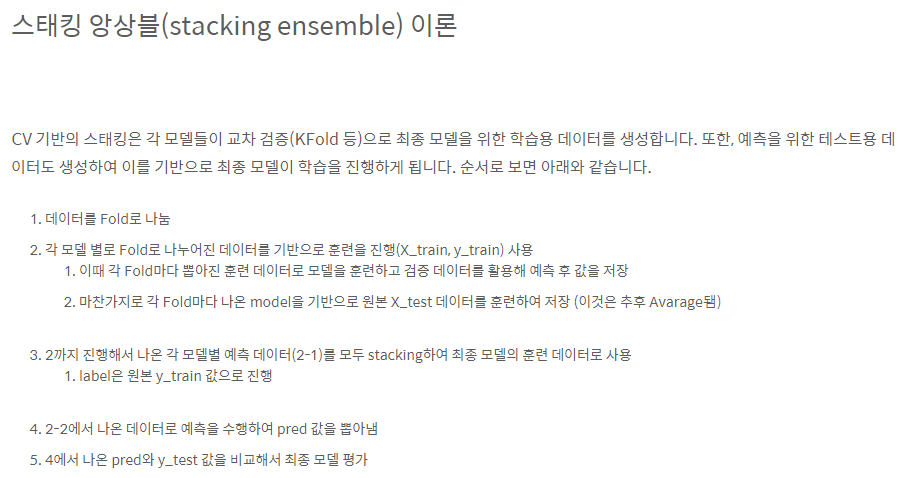

In [57]:
#기본 메타모델은 xgb, 나머지는  학습용
stack = StackingCVRegressor(regressors = (gbm, lgbm), meta_regressor = xgb)

In [58]:
stack.fit(np.array(X), y)

[01:58:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


StackingCVRegressor(cv=5,
                    meta_regressor=XGBRegressor(base_score=0.5,
                                                booster='gbtree',
                                                colsample_bylevel=1,
                                                colsample_bynode=1,
                                                colsample_bytree=0.5077862500013182,
                                                gamma=0.04360905322972397,
                                                importance_type='gain',
                                                learning_rate=0.08216538168209876,
                                                max_delta_step=0, max_depth=5,
                                                min_child_weight=1,
                                                missing=None, n_estimators=570,
                                                n_jobs=1, nthread=None,
                                                objecti...
                                  

In [59]:
pred_stc = np.expm1(stack.predict(np.array(test)))

In [60]:
#모든 모형들의 RMSE를 더하고 7로 나눔
submission['value'] = (pred_ngb + pred_cat + pred_xgb + pred_lgbm + pred_gbm + pred_vot + pred_stc) / 7

In [61]:
#모든 모형들의 RMSE를 곱하고 1/7 제곱을 취함
#이유?
submission['value'] = (pred_ngb * pred_cat * pred_xgb * pred_lgbm * pred_gbm * pred_vot * pred_stc) ** (1/7)

In [62]:
#데이터 프레임에서 특이점 검색 및 제외
#이적료의 경우 상하위 1%의 격차가 크므로 정확도를 높이기 위해 수동조정

#quantile : 사분위수를 구하는 함수(범위:0~1)
#0에 가까운 사분위수
q1 = submission['value'].quantile(0.0042)
#1에 가까운 사분위수
q2 = submission['value'].quantile(0.99)
# if x > q1 :
#   x=x
# else:
#   x= x*0.77
# if x > q1 :
#   x=x
# else:
#   x= x*1.1
# 가중치가 조절된 x를 value에서 호출하고 value에 대입
submission['value'] = submission['value'].apply(lambda x: x if x > q1 else x*0.77)
submission['value'] = submission['value'].apply(lambda x: x if x < q2 else x*1.1)

In [63]:
submission.to_csv('sub10112.csv', index = False)